In [54]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights, VGG16_Weights, ResNet18_Weights
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [56]:
# @title Funções Treino/teste, e plot dos gráfico
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [57]:
# Baixa e extrai o dataset
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  2069k      0  0:00:05  0:00:05 --:--:-- 2803k
Archive:  data/animais.zip
replace data/animais/val/tatu/10242.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/animais/val/tatu/10242.jpg  
  inflating: data/animais/val/tatu/10209.jpg  
  inflating: data/animais/val/tatu/10251.jpg  
  inflating: data/animais/val/tatu/10202.jpg  
  inflating: data/animais/val/tatu/10243.jpg  
  inflating: data/animais/val/tatu/10215.jpg  
  inflating: data/animais/val/tatu/10254.jpg  
  inflating: data/animais/val/tatu/10241.jpg  
  inflating: data/animais/val/tatu/10238.jpg  
  inflating: data/animais/val/tatu/10228.jpg  
  inflating: data/animais/val/tatu/10203.jpg  
  inflating: data/animais/val/tatu/10236.jpg  
  inflating:

In [58]:
# @title Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [59]:
model = models.resnet18(weights="IMAGENET1K_V1")

In [60]:
# @title Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [61]:
# @title Substituir a última camada de classificação
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [63]:
# @title Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Epoch 1, Train Loss: 0.717, Train Accuracy: 52.75%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.491, Val Accuracy: 81.15%


100%|██████████| 13/13 [00:01<00:00,  7.30it/s]


Epoch 2, Train Loss: 0.450, Train Accuracy: 81.25%
Epoch 2, Val Loss: 0.300, Val Accuracy: 87.70%


100%|██████████| 13/13 [00:01<00:00,  8.90it/s]


Epoch 3, Train Loss: 0.320, Train Accuracy: 86.75%
Epoch 3, Val Loss: 0.191, Val Accuracy: 91.80%


100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Epoch 4, Train Loss: 0.295, Train Accuracy: 88.25%
Epoch 4, Val Loss: 0.204, Val Accuracy: 92.62%


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Epoch 5, Train Loss: 0.266, Train Accuracy: 91.00%
Epoch 5, Val Loss: 0.155, Val Accuracy: 95.08%
Treinamento concluído


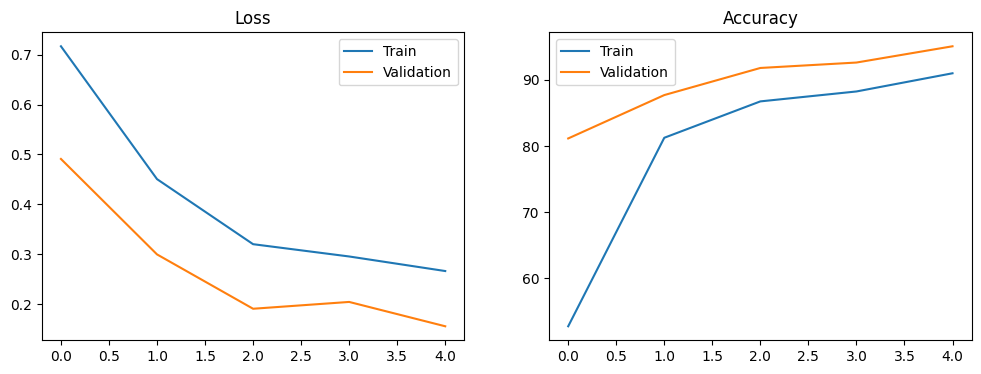

In [64]:
plot_history(history)

In [65]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 95.08%


In [66]:
# @title Plot do predict
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

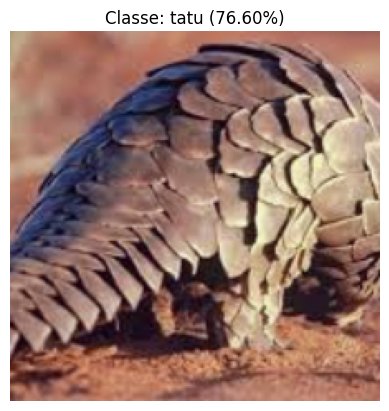

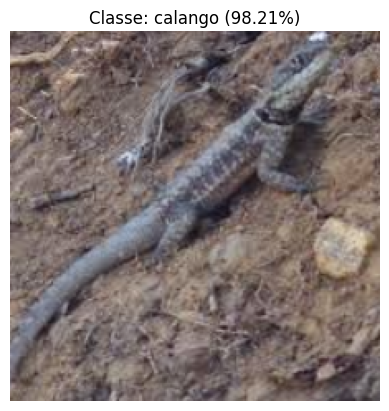

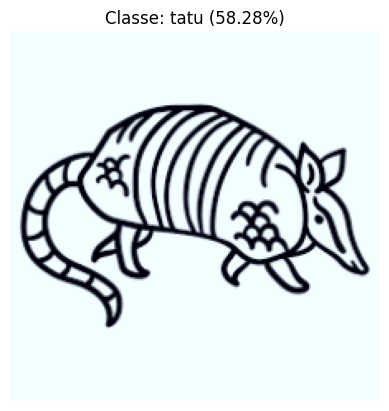

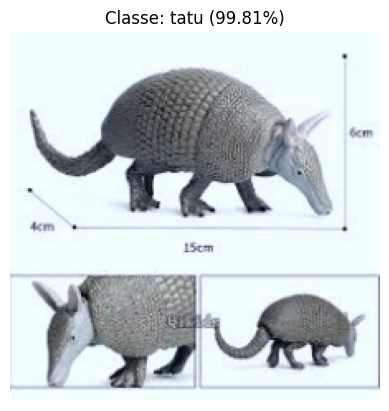

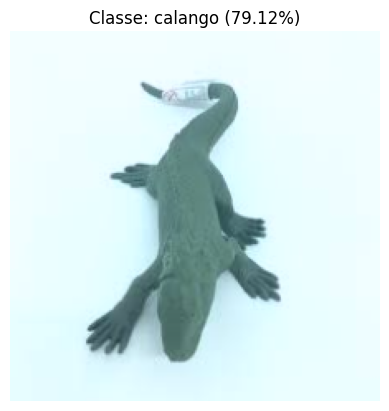

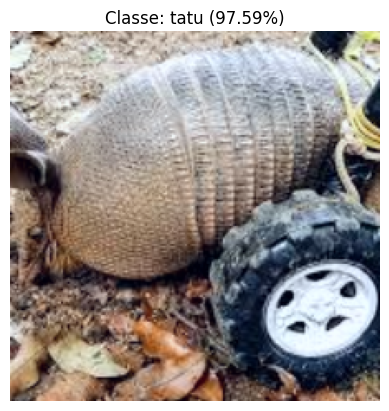

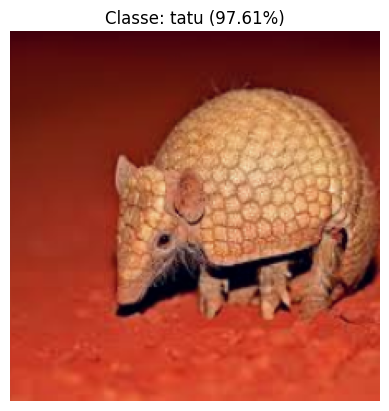

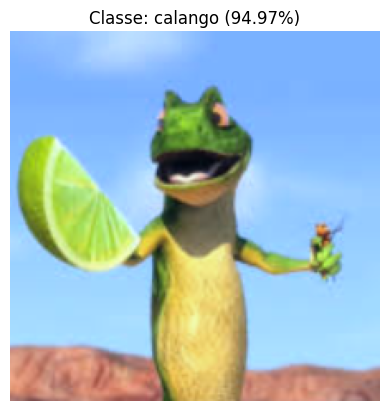

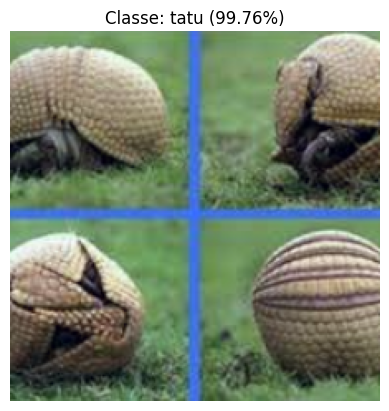

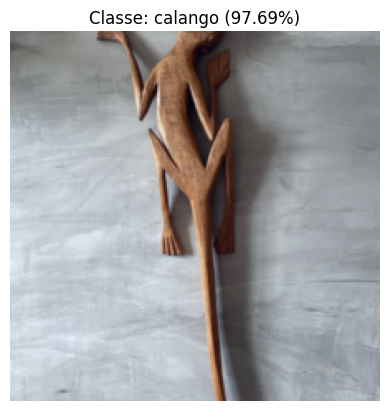

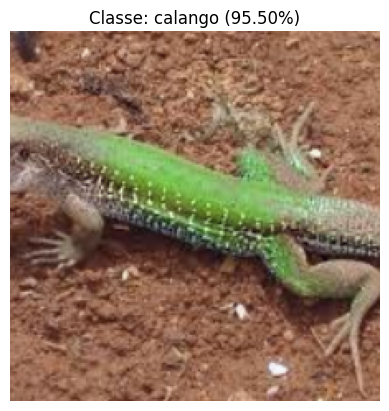

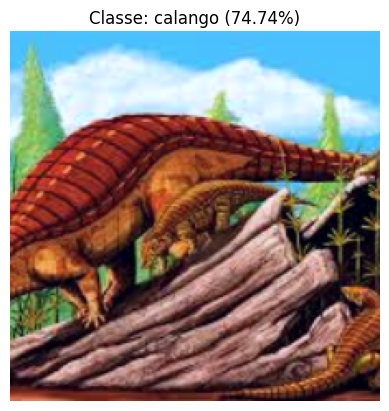

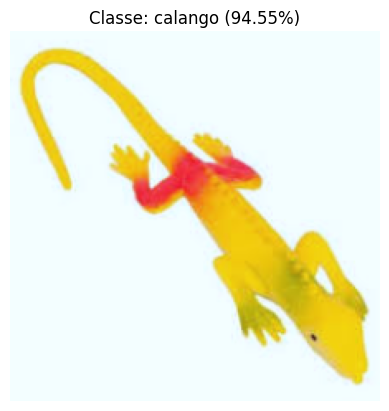

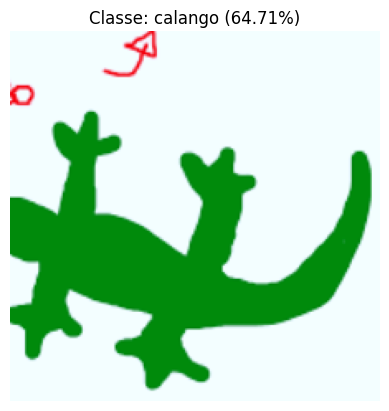

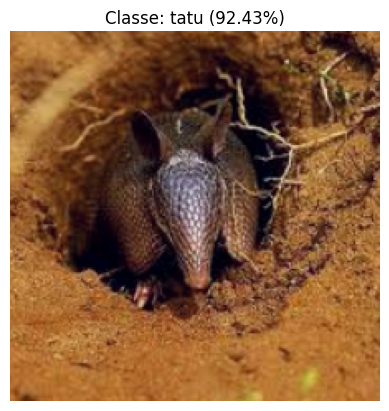

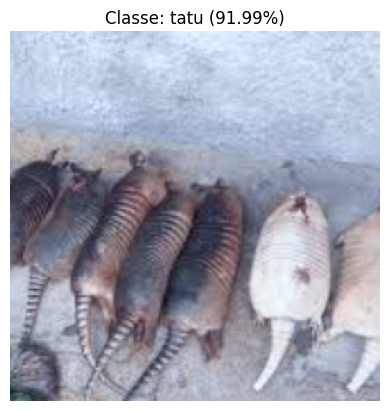

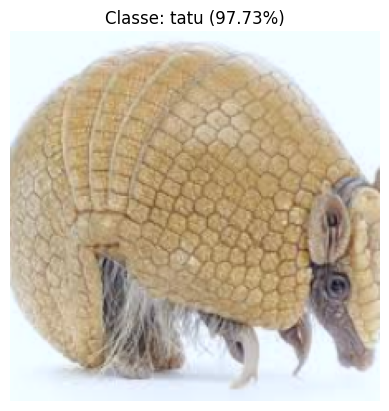

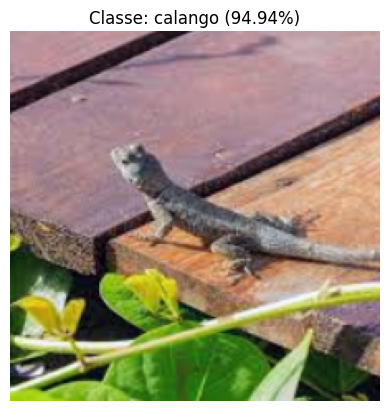

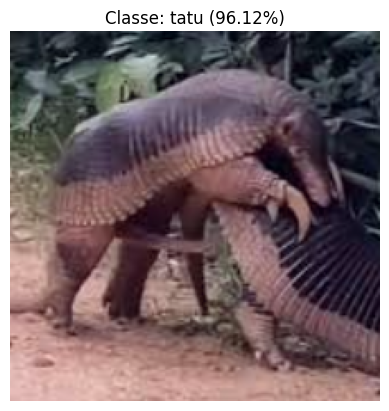

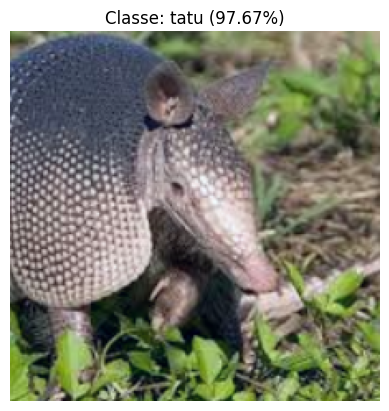

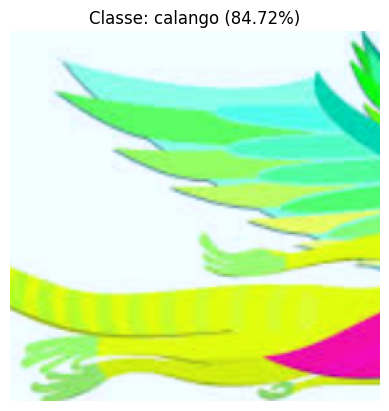

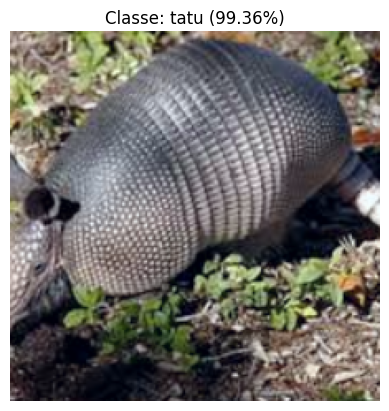

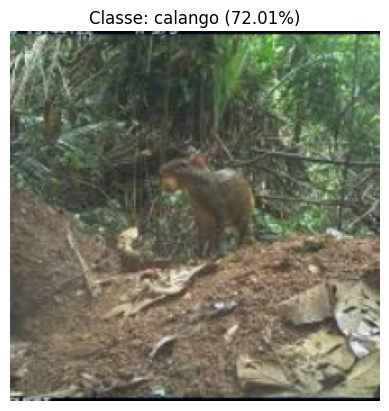

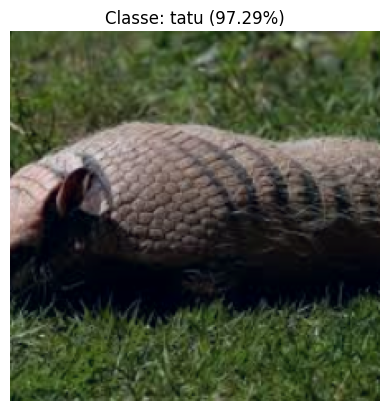

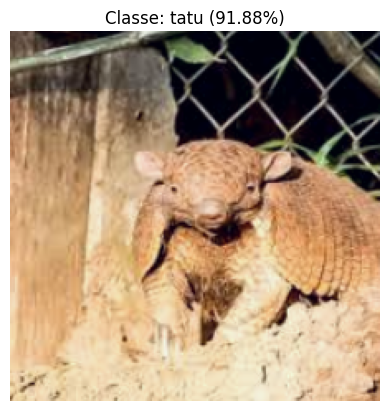

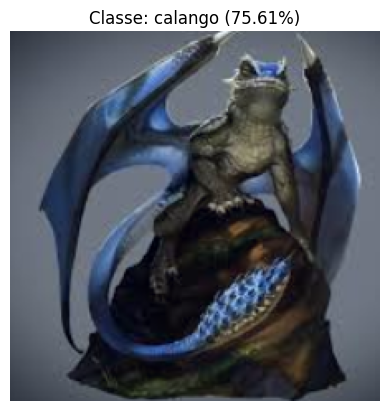

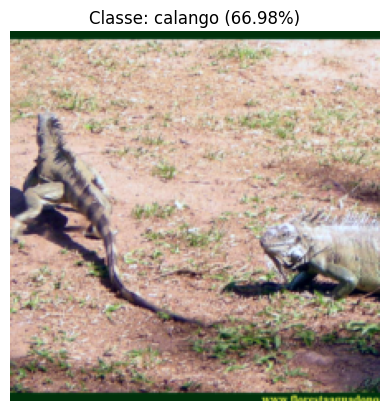

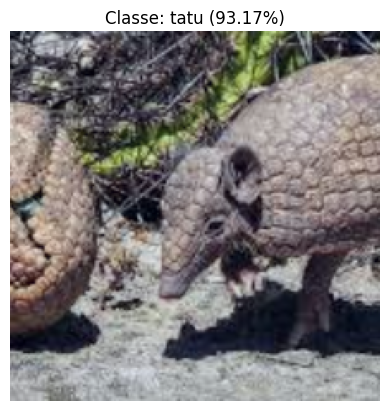

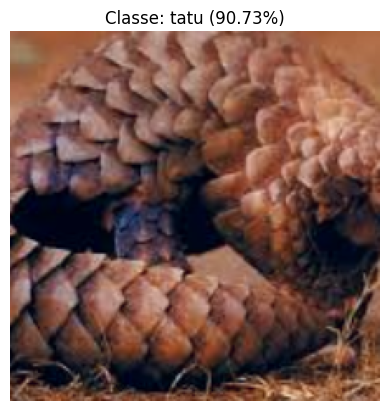

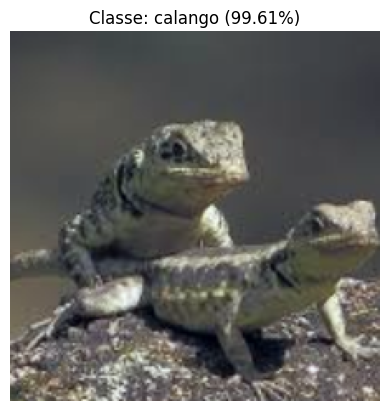

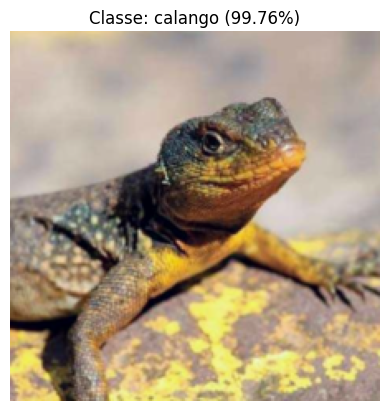

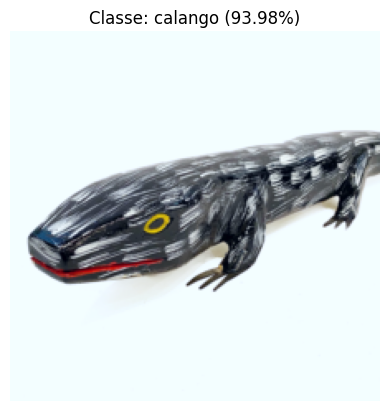

In [67]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


Epoch 1, Train Loss: 0.602, Train Accuracy: 66.00%
Epoch 1, Val Loss: 0.381, Val Accuracy: 92.62%


100%|██████████| 13/13 [00:01<00:00,  7.66it/s]


Epoch 2, Train Loss: 0.320, Train Accuracy: 90.00%
Epoch 2, Val Loss: 0.230, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:01<00:00,  8.40it/s]


Epoch 3, Train Loss: 0.233, Train Accuracy: 93.75%
Epoch 3, Val Loss: 0.201, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:02<00:00,  5.80it/s]


Epoch 4, Train Loss: 0.179, Train Accuracy: 94.25%
Epoch 4, Val Loss: 0.162, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:01<00:00,  8.48it/s]


Epoch 5, Train Loss: 0.162, Train Accuracy: 95.50%
Epoch 5, Val Loss: 0.158, Val Accuracy: 94.26%
Treinamento concluído


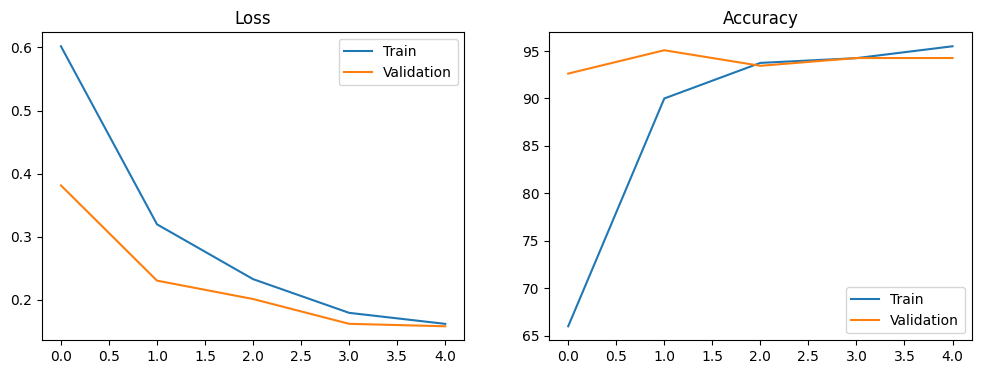

In [69]:
train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

model = models.resnet18(weights="IMAGENET1K_V1")
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False
# Substituir a última camada de classificação
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)
plot_history(history)

In [70]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 94.26%


Sem o Data Augmentation a acurácia da rede diminuiu menos de 1%. Em compensação, a acurácia de treino foi melhor que a acurácia de teste sem o Data Augmentation, resultando num overfiting

### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

100%|██████████| 13/13 [00:01<00:00,  8.29it/s]


Epoch 1, Train Loss: 0.751, Train Accuracy: 54.00%
Epoch 1, Val Loss: 0.500, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:01<00:00,  8.07it/s]


Epoch 2, Train Loss: 0.461, Train Accuracy: 76.50%
Epoch 2, Val Loss: 0.250, Val Accuracy: 91.80%


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Epoch 3, Train Loss: 0.328, Train Accuracy: 89.00%
Epoch 3, Val Loss: 0.189, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:01<00:00,  6.62it/s]


Epoch 4, Train Loss: 0.282, Train Accuracy: 90.00%
Epoch 4, Val Loss: 0.170, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


Epoch 5, Train Loss: 0.255, Train Accuracy: 89.00%
Epoch 5, Val Loss: 0.164, Val Accuracy: 95.90%
Treinamento concluído


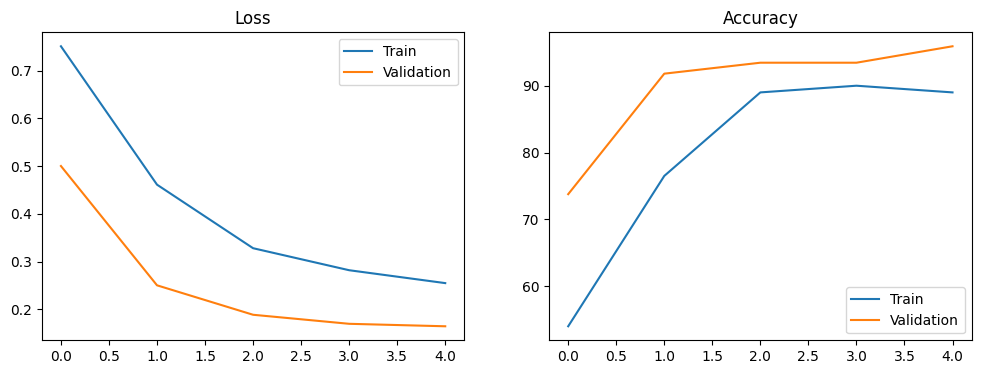

In [74]:
train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

model = models.resnet18(weights="IMAGENET1K_V1")
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False
# Descongelar uma camada específica
for param in model.layer3.parameters():
    param.requires_grad = False
# Substituir a última camada de classificação
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)
plot_history(history)

In [73]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 94.26%


Quando se descongela a camada 3 e mantém-se o Data Augmentation, não tem uma perda significativa na acurácia de teste, e não tem características de overfiting

### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

100%|██████████| 13/13 [00:03<00:00,  4.11it/s]


Epoch 1, Train Loss: 0.339, Train Accuracy: 85.00%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.163, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


Epoch 2, Train Loss: 0.143, Train Accuracy: 95.00%
Epoch 2, Val Loss: 0.114, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:03<00:00,  4.27it/s]


Epoch 3, Train Loss: 0.119, Train Accuracy: 95.50%
Epoch 3, Val Loss: 0.126, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:03<00:00,  4.19it/s]


Epoch 4, Train Loss: 0.094, Train Accuracy: 96.75%
Epoch 4, Val Loss: 0.108, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:03<00:00,  3.63it/s]


Epoch 5, Train Loss: 0.083, Train Accuracy: 96.50%
Epoch 5, Val Loss: 0.104, Val Accuracy: 95.08%
Treinamento concluído


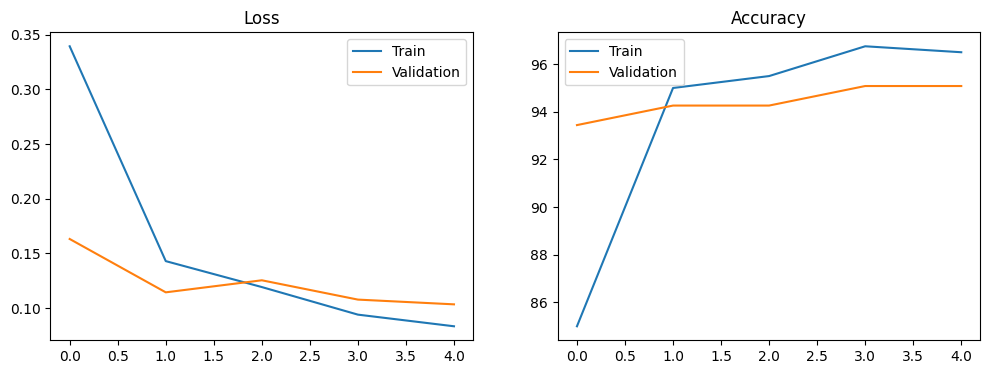

In [76]:
train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

model = models.vgg16(weights="IMAGENET1K_V1")
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False
# Substituir a última camada de classificação
# model.fc = nn.Linear(model.fc.in_features, 2)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)
plot_history(history)

In [77]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 95.08%


A acurácia de teste não mudou praticamente nada, porém, a acurácia de treino ficou maior que a de teste, sinal de overfitting.